# Import Libraries

In [52]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import matplotlib.ticker as mticker

# Open Hindcast files
### Remove bad file 

In [8]:
# Load and merge all NetCDF hindcast files into one dataset
bad_file = "waves_point_465809.0_lon151.400_lat-22.467_all_months.nc"
folder = "wave_hindcast_point"

good_files = [
    os.path.join(folder, f)
    for f in os.listdir(folder)
    if f.endswith(".nc") and f != bad_file
]

print(f"Good files found: {len(good_files)}")

wave = xr.open_mfdataset(
    good_files,
    combine="nested",
    concat_dim="point",
    chunks="auto",
    engine="netcdf4",
    parallel=False
)

wave

Good files found: 473


<xarray.Dataset> Size: 33MB
Dimensions:    (point: 473, time: 2904)
Coordinates:
    longitude  (point) float32 2kB 151.6 151.7 151.7 151.8 ... 152.0 152.1 152.1
    latitude   (point) float32 2kB -24.0 -24.0 -24.0 ... -22.47 -22.47 -22.47
  * time       (time) datetime64[ns] 23kB 2024-12-01 ... 2025-03-31T23:00:00....
Dimensions without coordinates: point
Data variables:
    hs         (point, time) float32 5MB dask.array<chunksize=(1, 2904), meta=np.ndarray>
    t02        (point, time) float32 5MB dask.array<chunksize=(1, 2904), meta=np.ndarray>
    fp         (point, time) float32 5MB dask.array<chunksize=(1, 2904), meta=np.ndarray>
    dir        (point, time) float32 5MB dask.array<chunksize=(1, 2904), meta=np.ndarray>
    dp         (point, time) float32 5MB dask.array<chunksize=(1, 2904), meta=np.ndarray>
    cge        (point, time) float32 5MB dask.array<chunksize=(1, 2904), meta=np.ndarray>
Attributes: (12/17)
    WAVEWATCH_III_version_number:           4.18b
    WAVEWATCH_III_switches:                 F90 NOGRB LRB4 DIST MPI NOPA UQ P...
    SIN4 namelist parameter BETAMAX:        1.33
    SDS4 namelist parameter WHITECAPWIDTH:  0.3
    product_name:                           ww3.aus_4m.202412.nc
    area:                                   4 min Australian grid
    ...                                     ...
    easternmost_longitude:                  175.0000000
    minimum_altitude:                       -12000 m
    maximum_altitude:                       9000 m
    altitude_resolution:                    n/a
    start_date:                             2024-12-01T00:00:00Z
    stop_date:                              2024-12-31T23:00:00Z

# Open wind files 

In [4]:
wind = xr.open_dataset(".../raw_data/cds/wind_bbox.nc", engine="netcdf4")
print(wind)

<xarray.Dataset> Size: 11MB
Dimensions:     (valid_time: 236, latitude: 81, longitude: 69)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 2kB 2025-02-01 ... 2025-03-31T18:...
  * latitude    (latitude) float64 648B -10.0 -10.25 -10.5 ... -29.75 -30.0
  * longitude   (longitude) float64 552B 143.0 143.2 143.5 ... 159.5 159.8 160.0
    expver      (valid_time) <U4 4kB ...
Data variables:
    u10         (valid_time, latitude, longitude) float32 5MB ...
    v10         (valid_time, latitude, longitude) float32 5MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-09-30T00:27 GRIB to CDM+CF via cfgrib-0.9.1...


In [9]:
# Load ERA5 wind dataset
wind = xr.open_dataset("raw_data/cds/wind_bbox.nc", engine="netcdf4")

# Standardise coordinate names
wind = wind.rename({"valid_time": "time"})

# Compute wind speed and direction
wind["wind_speed"] = np.sqrt(wind.u10**2 + wind.v10**2)
wind["wind_dir"] = (180 + np.degrees(np.arctan2(-wind.u10, -wind.v10))) % 360

# Align time format with wave data
wind["time"] = pd.to_datetime(wind.time.values)
wave["time"] = pd.to_datetime(wave.time.values)

# Interpolate wind data to match wave coordinates (time, lat, lon)
wind_interp = wind.interp(
    latitude=wave.latitude,
    longitude=wave.longitude,
    time=wave.time
)

# Merge into one combined dataset
wave_wind = xr.merge([wave, wind_interp], compat="override")

print(wave_wind)

<xarray.Dataset> Size: 77MB
Dimensions:     (point: 473, time: 2904)
Coordinates:
    longitude   (point) float32 2kB 151.6 151.7 151.7 ... 152.0 152.1 152.1
    latitude    (point) float32 2kB -24.0 -24.0 -24.0 ... -22.47 -22.47 -22.47
  * time        (time) datetime64[ns] 23kB 2024-12-01 ... 2025-03-31T23:00:00...
    number      int64 8B 0
    expver      (time) <U4 46kB '0001' '0001' '0001' ... '0001' '0001' '0001'
Dimensions without coordinates: point
Data variables:
    hs          (point, time) float32 5MB dask.array<chunksize=(1, 2904), meta=np.ndarray>
    t02         (point, time) float32 5MB dask.array<chunksize=(1, 2904), meta=np.ndarray>
    fp          (point, time) float32 5MB dask.array<chunksize=(1, 2904), meta=np.ndarray>
    dir         (point, time) float32 5MB dask.array<chunksize=(1, 2904), meta=np.ndarray>
    dp          (point, time) float32 5MB dask.array<chunksize=(1, 2904), meta=np.ndarray>
    cge         (point, time) float32 5MB dask.array<chunksize=(1, 2

# Set boundaries

In [10]:
# Get latitude/longitude arrays
lats = np.round(wave.latitude.values, 3)
lons = np.round(wave.longitude.values, 3)

# Combine into one 2-column array and drop duplicates
coords = np.unique(np.column_stack((lats, lons)), axis=0)

# Build DataFrame of unique coordinate pairs
unique_points = pd.DataFrame(coords, columns=["latitude", "longitude"])
print(unique_points)
print(f"Total unique points: {len(unique_points)}")

      latitude   longitude
0   -24.000000  151.600006
1   -24.000000  151.667007
2   -24.000000  151.733994
3   -24.000000  151.800003
4   -24.000000  151.867004
..         ...         ...
468 -22.466999  151.867004
469 -22.466999  151.934006
470 -22.466999  152.000000
471 -22.466999  152.067001
472 -22.466999  152.134003

[473 rows x 2 columns]
Total unique points: 473


# Standardise variable names

# This method did not work

In [11]:
# Convert to DataFrame for clarity
wave_df = wave.to_dataframe().reset_index()

# Group by unique (lat, lon)
grouped = wave_df.groupby(["latitude", "longitude"])

# Convert back to an xarray with a new dimension "point"
wave_points = grouped.apply(lambda x: x.set_index("time").sort_index())
wave_points = wave_points.to_xarray()

print(wave_points)

C:\Users\anika\AppData\Local\Temp\ipykernel_20284\4089006195.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wave_points = grouped.apply(lambda x: x.set_index("time").sort_index())


<xarray.Dataset> Size: 86MB
Dimensions:    (latitude: 24, longitude: 31, time: 2904)
Coordinates:
    longitude  (latitude, longitude, time) float32 9MB nan nan nan ... nan nan
    latitude   (latitude, longitude, time) float32 9MB nan nan nan ... nan nan
  * time       (time) datetime64[ns] 23kB 2024-12-01 ... 2025-03-31T23:00:00....
Data variables:
    point      (latitude, longitude, time) float64 17MB nan nan nan ... nan nan
    hs         (latitude, longitude, time) float32 9MB nan nan nan ... nan nan
    t02        (latitude, longitude, time) float32 9MB nan nan nan ... nan nan
    fp         (latitude, longitude, time) float32 9MB nan nan nan ... nan nan
    dir        (latitude, longitude, time) float32 9MB nan nan nan ... nan nan
    dp         (latitude, longitude, time) float32 9MB nan nan nan ... nan nan
    cge        (latitude, longitude, time) float32 9MB nan nan nan ... nan nan


### need to identify unique points and merge the new correct name

In [30]:
# Convert to DataFrame
wave_df = wave.to_dataframe().reset_index()

In [31]:
# Round lat/lon to reduce floating-point mismatches
wave_df["latitude"] = wave_df["latitude"].round(4)
wave_df["longitude"] = wave_df["longitude"].round(4)

In [32]:
# Create unique (lat, lon) pairs and assign a point ID directly
coords = list(zip(wave_df["latitude"], wave_df["longitude"]))
coord_to_point = {coord: i for i, coord in enumerate(sorted(set(coords)))}

In [33]:
# Map each row’s coordinates to its corresponding point ID
wave_df["point"] = [coord_to_point[(lat, lon)] for lat, lon in zip(wave_df["latitude"], wave_df["longitude"])]

In [34]:
# Verify success
print("Unique points:", len(set(wave_df["point"])))
print(wave_df[["latitude", "longitude", "point"]].head(10))

Unique points: 473
    latitude   longitude  point
0 -23.999901  151.600296      0
1 -23.999901  151.600296      0
2 -23.999901  151.600296      0
3 -23.999901  151.600296      0
4 -23.999901  151.600296      0
5 -23.999901  151.600296      0
6 -23.999901  151.600296      0
7 -23.999901  151.600296      0
8 -23.999901  151.600296      0
9 -23.999901  151.600296      0


In [35]:
# Convert back to xarray with point/time as the multi-index
wave_points = wave_df.set_index(["point", "time"]).to_xarray()

In [36]:
print(wave_points)

<xarray.Dataset> Size: 44MB
Dimensions:    (point: 473, time: 2904)
Coordinates:
  * point      (point) int64 4kB 0 1 2 3 4 5 6 7 ... 466 467 468 469 470 471 472
  * time       (time) datetime64[ns] 23kB 2024-12-01 ... 2025-03-31T23:00:00....
Data variables:
    hs         (point, time) float32 5MB 0.264 0.294 0.272 ... 1.34 1.31 1.272
    t02        (point, time) float32 5MB 4.43 4.55 4.25 4.25 ... 4.18 4.16 4.18
    fp         (point, time) float32 5MB 0.122 0.121 0.123 ... 0.193 0.195 0.197
    dir        (point, time) float32 5MB 45.6 47.0 44.7 45.9 ... 356.3 4.8 13.8
    dp         (point, time) float32 5MB 50.0 52.0 50.0 ... 330.0 333.0 336.0
    cge        (point, time) float32 5MB 0.2 0.3 0.2 0.3 0.2 ... 5.2 4.8 4.6 4.4
    longitude  (point, time) float32 5MB 151.6 151.6 151.6 ... 152.1 152.1 152.1
    latitude   (point, time) float32 5MB -24.0 -24.0 -24.0 ... -22.47 -22.47


### Make Lat and Long static to combine with wind 

In [37]:
# Extract unique lat/lon per point (first timestep)
latitudes = wave_points.latitude.isel(time=0)
longitudes = wave_points.longitude.isel(time=0)

# Assign as 1D coordinates instead of 2D variables
wave_points = wave_points.assign_coords({
    "latitude": ("point", latitudes.values),
    "longitude": ("point", longitudes.values)
})

# Remove the old 2D versions if they exist
wave_points = wave_points.drop_vars(["latitude", "longitude"])

print(wave_points)

<xarray.Dataset> Size: 33MB
Dimensions:  (point: 473, time: 2904)
Coordinates:
  * point    (point) int64 4kB 0 1 2 3 4 5 6 7 ... 466 467 468 469 470 471 472
  * time     (time) datetime64[ns] 23kB 2024-12-01 ... 2025-03-31T23:00:00.00...
Data variables:
    hs       (point, time) float32 5MB 0.264 0.294 0.272 ... 1.34 1.31 1.272
    t02      (point, time) float32 5MB 4.43 4.55 4.25 4.25 ... 4.18 4.16 4.18
    fp       (point, time) float32 5MB 0.122 0.121 0.123 ... 0.193 0.195 0.197
    dir      (point, time) float32 5MB 45.6 47.0 44.7 45.9 ... 356.3 4.8 13.8
    dp       (point, time) float32 5MB 50.0 52.0 50.0 52.0 ... 330.0 333.0 336.0
    cge      (point, time) float32 5MB 0.2 0.3 0.2 0.3 0.2 ... 5.2 4.8 4.6 4.4


In [38]:
# Reload or reuse the wind dataset
# wind = xr.open_dataset("era5_wind_alfred_2025.nc", engine="netcdf4")

# Flatten any non-1D coordinates
for coord_name, coord in list(wind.coords.items()):
    if coord.ndim > 1:
        print(f"Flattening non-1D coord: {coord_name}")
        # keep only the first value along the extra dimension
        wind = wind.isel({coord_name: 0}) if coord_name in wind.dims else wind.drop_vars(coord_name, errors="ignore")

# If a MultiIndex exists (cfgrib style), reset it
for dim in list(wind.dims):
    if isinstance(wind[dim].values[0], (tuple, np.void)):
        print(f"Resetting MultiIndex for {dim}")
        wind = wind.reset_index(dim)

# Drop unneeded cfgrib coords if they remain
for v in ["number", "expver"]:
    if v in wind.coords:
        wind = wind.drop_vars(v)

print("Cleaned ERA5 structure:")
print(wind)

Cleaned ERA5 structure:
<xarray.Dataset> Size: 21MB
Dimensions:     (time: 236, latitude: 81, longitude: 69)
Coordinates:
  * time        (time) datetime64[ns] 2kB 2025-02-01 ... 2025-03-31T18:00:00
  * latitude    (latitude) float64 648B -10.0 -10.25 -10.5 ... -29.75 -30.0
  * longitude   (longitude) float64 552B 143.0 143.2 143.5 ... 159.5 159.8 160.0
Data variables:
    u10         (time, latitude, longitude) float32 5MB 6.76 6.726 ... 6.329
    v10         (time, latitude, longitude) float32 5MB -7.531 -7.392 ... 0.4354
    wind_speed  (time, latitude, longitude) float32 5MB 10.12 9.994 ... 6.344
    wind_dir    (time, latitude, longitude) float32 5MB 138.1 137.7 ... 86.06
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-09-30T0

In [41]:
# Extract one lat/lon per hindcast point (1D already)
latitudes = wave_wind.latitude
longitudes = wave_wind.longitude
for i in range(len(latitudes)):
    lat = float(latitudes[i])
    lon = float(longitudes[i])
    try:
        # Interpolate ERA5 data (spatially + temporally)
        wind_point = wind.interp(
            latitude=lat,
            longitude=lon,
            time=wave_wind.time,
            method="nearest"
        )

        # Add explicit point dimension
        wind_point = wind_point.expand_dims({"point": [i]})
        interp_list.append(wind_point)

    except Exception as e:
        print(f"Skipped {lat}, {lon}: {e}")

# Combine and merge
if interp_list:
    wind_interp = xr.concat(interp_list, dim="point")
    wind_interp = wind_interp.assign_coords({
        "latitude": ("point", latitudes.values),
        "longitude": ("point", longitudes.values)
    })

    # Drop duplicate vars if present
    drop_vars = [v for v in ["latitude", "longitude"] if v in wind_interp.variables]
    wind_interp = wind_interp.drop_vars(drop_vars)

    # Merge with wave data
    wave_wind = xr.merge([wave_wind, wind_interp], compat="override")

    print("Re-interpolated successfully.")
    print(wave_wind)
else:
    print("No valid interpolated wind data.")

Re-interpolated successfully.
<xarray.Dataset> Size: 38MB
Dimensions:     (point: 473, time: 1416)
Coordinates:
    longitude   (point) float32 2kB 151.6 151.7 151.7 ... 152.0 152.1 152.1
    latitude    (point) float32 2kB -24.0 -24.0 -24.0 ... -22.47 -22.47 -22.47
  * time        (time) datetime64[ns] 11kB 2025-02-01 ... 2025-03-31T23:00:00...
    number      int64 8B 0
    expver      (time) <U4 23kB '0001' '0001' '0001' ... '0001' '0001' '0001'
  * point       (point) int64 4kB 0 1 2 3 4 5 6 ... 466 467 468 469 470 471 472
Data variables:
    hs          (point, time) float32 3MB dask.array<chunksize=(1, 1416), meta=np.ndarray>
    t02         (point, time) float32 3MB dask.array<chunksize=(1, 1416), meta=np.ndarray>
    fp          (point, time) float32 3MB dask.array<chunksize=(1, 1416), meta=np.ndarray>
    dir         (point, time) float32 3MB dask.array<chunksize=(1, 1416), meta=np.ndarray>
    dp          (point, time) float32 3MB dask.array<chunksize=(1, 1416), meta=np.ndarr

# Start on time series and analysis 
### Set time

In [42]:
print("Wave time span :", str(wave_wind.time.min().values), "→", str(wave_wind.time.max().values))
print("Wind time span :", str(wind.time.min().values), "→", str(wind.time.max().values))

Wave time span : 2025-02-01T00:00:00.000000000 → 2025-03-31T23:00:00.000013440
Wind time span : 2025-02-01T00:00:00.000000000 → 2025-03-31T18:00:00.000000000


In [43]:
# Clip the dataset to Feb–Mar 2025
wave_wind = wave_wind.sel(time=slice("2025-02-01", "2025-03-31"))
print(wave_wind.time.min().values, "→", wave_wind.time.max().values)

2025-02-01T00:00:00.000000000 → 2025-03-31T23:00:00.000013440


### Divide the CBG equally

In [45]:
# Determine equal thirds of the latitude range
lat_min = float(wave_wind.latitude.min())
lat_max = float(wave_wind.latitude.max())
lat_thirds = np.linspace(lat_min, lat_max, 4)  # three zones = 4 boundaries

print("Latitude boundaries:", lat_thirds)

def assign_equal_region(lat):
    if lat >= lat_thirds[2]:
        return "North"
    elif lat >= lat_thirds[1]:
        return "Central"
    else:
        return "South"

latitudes = wave_wind.latitude.values
regions = [assign_equal_region(float(lat)) for lat in latitudes]
wave_wind = wave_wind.assign_coords(region=("point", regions))

Latitude boundaries: [-23.9998703  -23.48875682 -22.97764333 -22.46652985]


## Load in reefs

In [47]:
reefs = pd.read_csv("capricorn_bunker_reefs.csv")
print(reefs.head())       # show the first few rows
print(reefs.columns)      # show the exact column names

            REEF_NAME   LATITUDE   LONGITUDE
0  NORTH REEF (NORTH) -23.183333  151.908333
1     BROOMFIELD REEF -23.275000  151.941667
2   WRECK ISLAND REEF -23.333333  151.966667
3       ONE TREE REEF -23.500000  152.066667
4        FITZROY REEF -23.625000  152.158333
Index(['REEF_NAME', 'LATITUDE', 'LONGITUDE'], dtype='object')


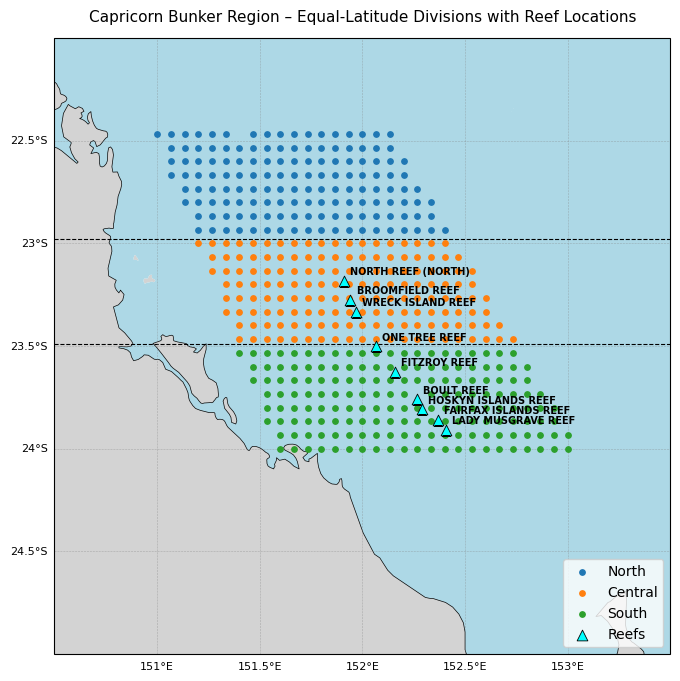

In [57]:
# Load reef data
reefs = pd.read_csv(".../raw_data/cyclone_data/capricorn_bunker_reefs.csv)

# Compute latitude boundaries (equal thirds
latitudes = wave_wind.latitude.values
longitudes = wave_wind.longitude.values
regions = wave_wind.region.values

lat_min = np.nanmin(latitudes)
lat_max = np.nanmax(latitudes)
lat_bounds = np.linspace(lat_min, lat_max, 4)  # 3 equal zones = 4 boundaries

# --- Plot setup ---
colors = {"North": "tab:blue", "Central": "tab:orange", "South": "tab:green"}

fig, ax = plt.subplots(figsize=(8, 8),
                       subplot_kw={"projection": ccrs.PlateCarree()})

# --- Base map ---
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor="lightgrey")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
ax.set_extent([150.5, 153.5, -25, -22], crs=ccrs.PlateCarree())

# Plot wave points by region
for region in ["North", "Central", "South"]:
    mask = np.array(regions) == region
    ax.scatter(np.array(longitudes)[mask],
               np.array(latitudes)[mask],
               color=colors[region],
               label=region,
               s=15,
               transform=ccrs.PlateCarree(),
               zorder=3)

# Add dashed latitude division lines
for bound in lat_bounds[1:-1]:
    ax.axhline(bound, color="black", linestyle="--", linewidth=0.8)

# Plot reef locations from CSV
ax.scatter(reefs["LONGITUDE"], reefs["LATITUDE"],
           marker="^",             # triangle
           s=60,
           facecolor="cyan",
           edgecolor="black",
           linewidth=0.6,
           transform=ccrs.PlateCarree(),
           zorder=5,
           label="Reefs")

# Add reef name labels
for _, row in reefs.iterrows():
    ax.text(row["LONGITUDE"] + 0.03, row["LATITUDE"] + 0.03, row["REEF_NAME"],
            fontsize=7, color="black", weight="bold",
            transform=ccrs.PlateCarree(), zorder=6)

# Latitude/Longitude labels
gl = ax.gridlines(draw_labels=True, linewidth=0.4, color="gray", alpha=0.5, linestyle="--")
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(150.5, 153.6, 0.5))
gl.ylocator = mticker.FixedLocator(np.arange(-25, -21.9, 0.5))
gl.xlabel_style = {"size": 8}
gl.ylabel_style = {"size": 8}

# Title and legend
ax.set_title("Capricorn Bunker Region – Equal-Latitude Divisions with Reef Locations",
             fontsize=11, pad=12)
ax.legend(loc="lower right")

plt.show()

### Mathematically transform wave data

In [58]:
# Compute mean per region
region_mean = wave_wind.groupby("region").mean(dim="point")
print(region_mean)

<xarray.Dataset> Size: 272kB
Dimensions:     (region: 3, time: 1416)
Coordinates:
  * time        (time) datetime64[ns] 11kB 2025-02-01 ... 2025-03-31T23:00:00...
    number      int64 8B 0
    expver      (time) <U4 23kB '0001' '0001' '0001' ... '0001' '0001' '0001'
  * region      (region) object 24B 'Central' 'North' 'South'
Data variables:
    hs          (region, time) float32 17kB dask.array<chunksize=(1, 1416), meta=np.ndarray>
    t02         (region, time) float32 17kB dask.array<chunksize=(1, 1416), meta=np.ndarray>
    fp          (region, time) float32 17kB dask.array<chunksize=(1, 1416), meta=np.ndarray>
    dir         (region, time) float32 17kB dask.array<chunksize=(1, 1416), meta=np.ndarray>
    dp          (region, time) float32 17kB dask.array<chunksize=(1, 1416), meta=np.ndarray>
    cge         (region, time) float32 17kB dask.array<chunksize=(1, 1416), meta=np.ndarray>
    u10         (region, time) float64 34kB -9.375 -9.54 -9.705 ... nan nan nan
    v10         

In [55]:
rho = 1025  # seawater density (kg/m³)
g = 9.81    # gravity (m/s²)

# Derived energy and power
region_mean["wave_energy"] = (1/8) * rho * g * (region_mean.hs ** 2)
region_mean["wave_power"]  = (rho * g**2 * (region_mean.hs ** 2) * region_mean.t02) / (32 * np.pi)

print(region_mean)

<xarray.Dataset> Size: 306kB
Dimensions:      (region: 3, time: 1416)
Coordinates:
  * time         (time) datetime64[ns] 11kB 2025-02-01 ... 2025-03-31T23:00:0...
    number       int64 8B 0
    expver       (time) <U4 23kB '0001' '0001' '0001' ... '0001' '0001' '0001'
  * region       (region) object 24B 'Central' 'North' 'South'
Data variables:
    hs           (region, time) float32 17kB dask.array<chunksize=(1, 1416), meta=np.ndarray>
    t02          (region, time) float32 17kB dask.array<chunksize=(1, 1416), meta=np.ndarray>
    fp           (region, time) float32 17kB dask.array<chunksize=(1, 1416), meta=np.ndarray>
    dir          (region, time) float32 17kB dask.array<chunksize=(1, 1416), meta=np.ndarray>
    dp           (region, time) float32 17kB dask.array<chunksize=(1, 1416), meta=np.ndarray>
    cge          (region, time) float32 17kB dask.array<chunksize=(1, 1416), meta=np.ndarray>
    u10          (region, time) float64 34kB -9.375 -9.54 -9.705 ... nan nan nan
    v

### Define cyclone

In [60]:
def detect_events(hs_series):
    """Detect high-energy events for a single region."""
    high2 = hs_series > 2
    high3 = hs_series > 3
    events = []
    in_event = False
    start = None

    for i in range(len(hs_series)):
        if high3.iloc[i] or high2.iloc[i]:
            if not in_event:
                start = hs_series.index[i]
                in_event = True
        else:
            if in_event:
                end = hs_series.index[i]
                dur = (end - start).total_seconds() / 3600
                if dur >= 72 or (hs_series[start:end] > 3).any():
                    events.append((start, end))
                in_event = False

    # Merge events within 24h
    merged = []
    for s, e in events:
        if not merged or (s - merged[-1][1]).total_seconds() / 3600 > 24:
            merged.append([s, e])
        else:
            merged[-1][1] = e
    return merged


# Detect events for all regions
event_dict = {}

for region in region_mean.region.values:
    hs = region_mean.sel(region=region)["hs"].to_pandas().resample("1h").mean()
    event_dict[region] = detect_events(hs)
    print(f"\n{region} region:")
    for s, e in event_dict[region]:
        print(f"  {s:%Y-%m-%d %H:%M} → {e:%Y-%m-%d %H:%M}")


Central region:
  2025-02-25 11:00 → 2025-03-02 16:00

North region:
  2025-02-22 05:00 → 2025-02-22 13:00
  2025-02-25 08:00 → 2025-03-02 19:00

South region:
  2025-02-26 05:00 → 2025-03-02 13:00


### Ensure region_mean autimatically carries over to derived variables

In [64]:
if "wave_power" not in region_mean:
    rho = 1025  # seawater density (kg/m³)
    g = 9.81    # gravity (m/s²)
    region_mean["wave_power"] = (rho * g**2 * (region_mean.hs ** 2) * region_mean.t02) / (32 * np.pi)
    
#Ensure output folder exists
os.makedirs("region_timeseries_figures", exist_ok=True)

# ordered variables & title
variables = ["hs", "t02", "wave_power", "dir", "wind_speed", "wind_dir"]
titles = [
    "Sig Wave Height (m)",       # updated label
    "Mean Wave Period (T02, s)",
    "Wave Power (W/m)",
    "Wave Direction (°)",
    "Wind Speed (m/s)",
    "Wind Direction (°)"
]

region_order = ["North", "Central", "South"]
colors = {"North": "tab:blue", "Central": "tab:orange", "South": "tab:green"}

for region in region_order:
    fig, axs = plt.subplots(
        len(variables), 1, figsize=(12, 12), sharex=True
    )

    for ax, var, title in zip(axs, variables, titles):
        # Plot time series
        ax.plot(
            region_mean.time,
            region_mean.sel(region=region)[var],
            color=colors[region],
            linewidth=1.3,
            label=region
        )

        # Highlight cyclone events for this region
        for s, e in event_dict[region]:
            ax.axvspan(s, e, color=colors[region], alpha=0.15, zorder=0)

        ax.set_ylabel(title, labelpad=8)
        ax.grid(alpha=0.3)
        ax.legend(loc="upper right", frameon=False, fontsize=8)
        ax.set_title(title, fontsize=10, pad=6)

    axs[-1].set_xlabel("Time (Feb–Mar 2025)", labelpad=6)

    # Add a supertitle with enough margin space above plots
    plt.suptitle(
        f"{region} Region – Hydrodynamic & Wind Conditions (Cyclone Alfred)",
        fontsize=13,
        y=0.93  # lowered slightly to sit above top subplot
    )

    # Adjust layout manually for cleaner spacing
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save high-resolution figures
    png_path = f"region_timeseries_figures/{region.lower()}_timeseries.png"
    pdf_path = f"region_timeseries_figures/{region.lower()}_timeseries.pdf"
    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, dpi=300, bbox_inches="tight")
    print(f"Saved {png_path} and {pdf_path}")

    plt.close(fig)

Saved region_timeseries_figures/north_timeseries.png and region_timeseries_figures/north_timeseries.pdf
Saved region_timeseries_figures/central_timeseries.png and region_timeseries_figures/central_timeseries.pdf
Saved region_timeseries_figures/south_timeseries.png and region_timeseries_figures/south_timeseries.pdf


In [68]:
# Select key variables from region_mean
vars_to_summarise = ["hs", "t02", "wave_power", "dir", "wind_speed", "wind_dir"]

# Convert to DataFrame
df = region_mean[vars_to_summarise].to_dataframe().reset_index()

# Compute summary stats for each region
summary = (
    df.groupby("region")[vars_to_summarise]
      .agg(["mean", "max", "min", "std"])
)

# Flatten multi-index columns
summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
summary.reset_index(inplace=True)

# Round values
summary = summary.round(3)

# Save to Excel in current directory
output_path = "Regional_Summary.xlsx"
summary.to_excel(output_path, index=False)

print(f"Regional summary table saved as: {output_path}")
print(summary)


Regional summary table saved as: Regional_Summary.xlsx
    region  hs_mean  hs_max  hs_min  hs_std  t02_mean  t02_max  t02_min  \
0  Central    1.912   5.406   0.901   0.769     5.237    8.705    3.878   
1    North    1.985   5.234   0.984   0.780     5.365    9.454    3.918   
2    South    1.785   5.309   0.752   0.719     5.071    8.065    3.813   

   t02_std  wave_power_mean  ...  dir_min    dir_std  wind_speed_mean  \
0    0.902     24096.480469  ...   14.928  16.166000            8.371   
1    0.980     26283.542969  ...    9.117  16.891001            8.408   
2    0.793     20358.349609  ...   15.829  15.547000            8.125   

   wind_speed_max  wind_speed_min  wind_speed_std  wind_dir_mean  \
0          14.893           1.924           2.717        261.288   
1          14.323           1.369           2.678        261.515   
2          14.918           1.735           2.643        262.405   

   wind_dir_max  wind_dir_min  wind_dir_std  
0       349.157        22.968   